## EECS 491 Assignment 4

Due Wed Apr 21 before midnight. 100 points total.

### Submitting assignments to Canvas

- For jupyter notebooks, submit the .ipynb file and a pdf export of the notebook.
- Make sure you check that the pdf export represents the latest state of your notebook and that the equations and figures are properly rendered.

- If your are not using notebooks, writeup your assignment using latex and submit a pdf with your code.  The writeup should include relevant code with description if it can fit on a page.  

- Use the following format for filenames:
  - `EECS491-A4-yourcaseid.ipynb`
  - `EECS491-A4-yourcaseid.pdf`

- If you have more than these two files, put any additional files in a directory named `EECS491-A4-yourcaseid`. Do not include binaries or large data files. Then zip this directory and submit it with the name `EECS491-A4-yourcaseid.zip`.  Do not use other compression formats.  The `.ipynb` file can be included in the zipped directory, but make sure you submit the `.pdf` file along with the `.zip` file.  This is so it appears at the top level on canvas, which allows for easier grading.

In [36]:
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms 
import pandas as pd

### Exercise 1. Multivariate Gaussians (10 points)

1.1 (5 pts) Consider the 2D normal distribution

$$ p(x,y) \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma}) $$

Define three separate 2D covariance matrices $\mathbf{\Sigma}$ for each of the following cases: $x$ and $y$ are uncorrelated; $x$ and $y$ are correlated; and $x$ and $y$ are anti-correlated.  Plot samples from these distributions to show these properties.  Use a different mean for each.  Make sure your plots show the density. <br><br>
A covariance matrix for an uncorrelated pair of variables would have the diagonal as 1 because each variable is correlated with itself and the opposites as 0 since the variables would be entirely uncorrelated. The covariance matrix would looks as follows:
\begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix}
A covariance matrix for a correlated pair of variables would have the diagonal as 1 because each variable is correlated with itself and the opposites as 1 since the variables are correlated. The covariance matrix would appear as follows:
\begin{bmatrix}
1 & 0.9 \\
0.9 & 1 \\
\end{bmatrix}
Anticorrelated variables would have a negative correlation coefficient. Therefore, this covariance matrix would be similar to the one shown above, with different sign:
\begin{bmatrix}
1 & -0.9 \\
-0.9 & 1 \\
\end{bmatrix}

Consider the following sets of data (20 observations each) which were randomly generated using the "numpy" python package. To make them correlated, anticorrelated, or not, we can randomize or order them to plot the points.

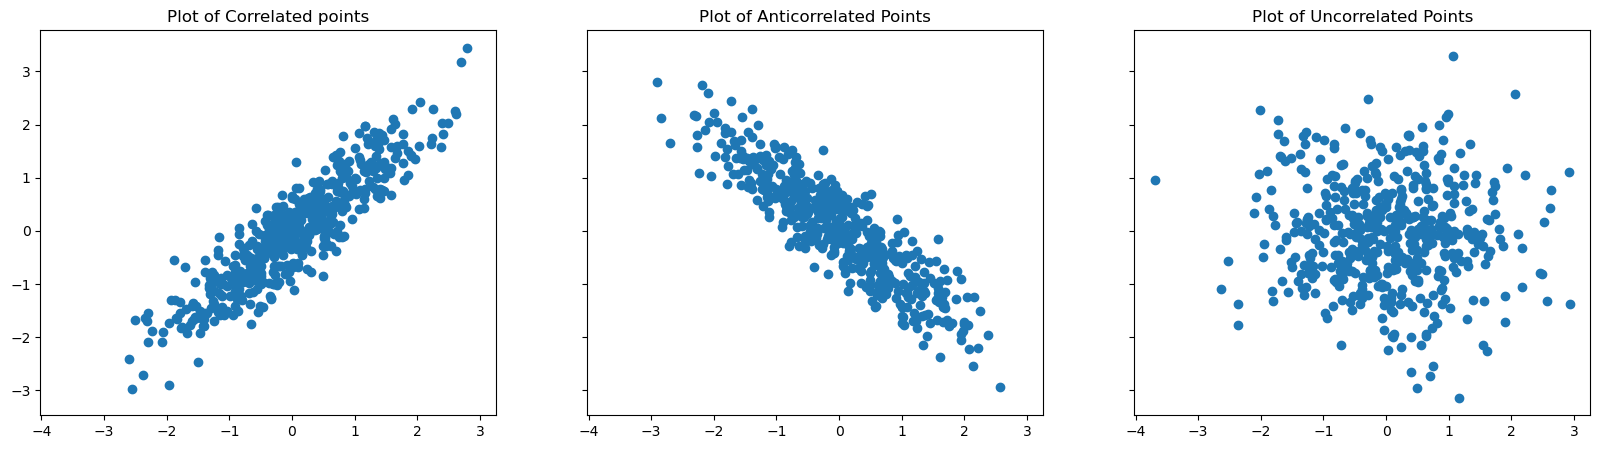

In [37]:
# set up for plotting
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(20, 5)
#fig.axes("equal")

# correlated
corr_x, corr_y = np.random.multivariate_normal([0,0], [[1, 0.9], [0.9, 1]], 500).T
ax[0].scatter(corr_x, corr_y)
ax[0].set_title("Plot of Correlated points")

# anticorrelated
anti_x, anti_y = np.random.multivariate_normal([0,0], [[1, -0.9], [-0.9, 1]], 500).T
ax[1].scatter(anti_x, anti_y)
ax[1].set_title("Plot of Anticorrelated Points")

# uncorrelated
uncorr_x, uncorr_y = np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], 500).T
ax[2].scatter(uncorr_x, uncorr_y)
ax[2].set_title("Plot of Uncorrelated Points")

# plot
plt.show()

1.2 (5 pts) Compute the principal axes for each of these distributions, i.e. the eigenvectors of the covariance matrices.  Use can use a linear algebra package. Plot the samples again, but this time overlay the 1, 2, and 3-sigma contours and with the scaled eigenvectors.<br><br>
First, for the correlated data:

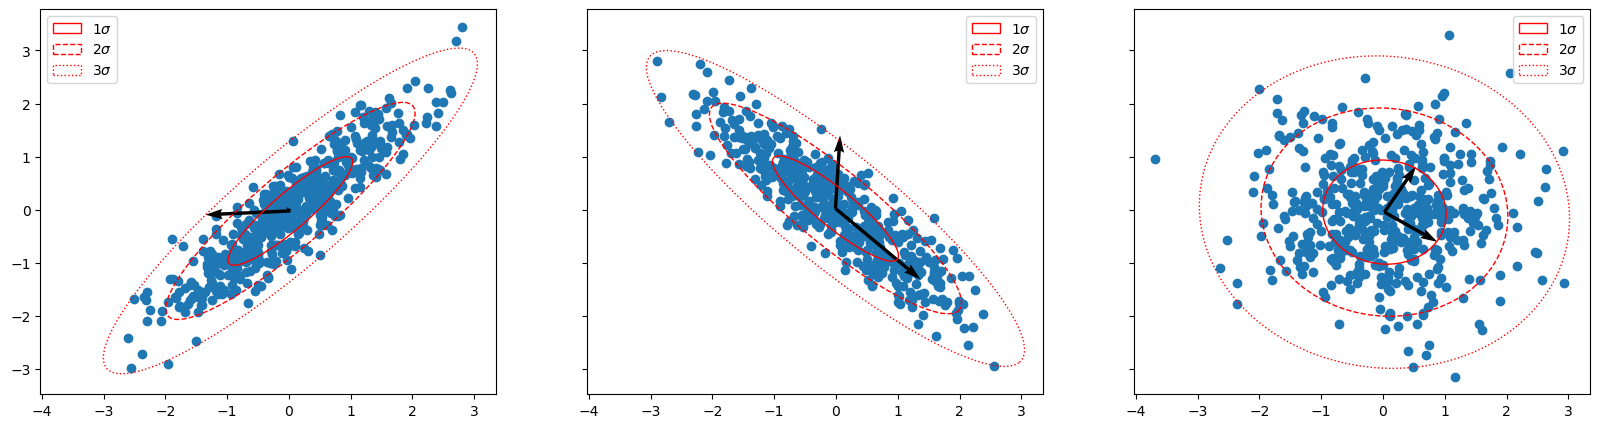

In [38]:
# set up plotting
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(20, 5)

# calculate and plot for each of correlated, anticorrlated, uncorrelated
distributions = [[corr_x, corr_y], [anti_x, anti_y], [uncorr_x, uncorr_y]]
for i,points in enumerate(distributions):
    # covariance
    cov = np.cov(points[0], points[1])
    
    # eigs
    eig_val, eig_vec = np.linalg.eig(cov)
    eig_vec = eig_vec.T
    
    # calculate quiver parameters
    x, y = np.mean(points[0]), np.mean(points[1])
    u1, v1, u2, v2 = eig_val[0]*eig_vec[0][0], eig_val[0]*eig_vec[0][1], eig_val[1]*eig_vec[1][0], eig_val[0]*eig_vec[1][1]
    
    # plot scaled eigenvectors
    ax[i].scatter(points[0], points[1])
    
    # plot sigma contours
    for sigma,style in zip([1, 2, 3], ["-", "--", ":"]):
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor="none", edgecolor="r", linestyle=style, label=f"{sigma}$\sigma$")

        # scale x and y
        scale_x = np.sqrt(cov[0, 0]) * sigma
        scale_y = np.sqrt(cov[1, 1]) * sigma

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(x, y)

        ellipse.set_transform(transf + ax[i].transData)
        ax[i].add_patch(ellipse)
        ax[i].legend()
        
    ax[i].quiver(x, y, u1, v1, angles="xy", scale_units="xy", scale=1)
    ax[i].quiver(x, y, u2, v2, angles="xy", scale_units="xy", scale=1)
    
plt.show()

### Exercise 2. Linear Gaussian Models (20 pts)

Consider two independent multi-dimensional Gaussian random vector variables
$
\def\bx{\mathbf{x}}
\def\bz{\mathbf{z}}
\def\by{\mathbf{y}}
\def\bm{\mathbf{m}}
\def\mbmu{\mathbf{\mu}} % don't collide with \bm
\def\bS{\mathbf{\Sigma}}
\def\bA{\mathbf{A}}
\def\bB{\mathbf{B}}
\def\bc{\mathbf{c}}
\def\N{\mathcal{N}}
$

$$
\begin{aligned}
p(\bx) &=& \mathcal{N}(\bx | \mbmu_x, \bS_x) \\
p(\bz) &=& \mathcal{N}(\bz | \mbmu_z, \bS_z)
\end{aligned}
$$

Now consider a third variable that is the sum of the first two:

$$
\by = \bx + \bz
$$

2.1 (5 pts) What is the expression for the distribution $p(\by)$?

We know the characteristic functions of x and z as:
$$ \phi_x(u) = e^{(iu^{T}\mu_x-\frac{1}{2}u^{T}\sum_xu)} $$
$$ \phi_z(u) = e^{(iu^{T}\mu_z-\frac{1}{2}u^{T}\sum_zu)} $$
We know that x and z are independent, so the sum of the two distributions will also be a normal distributions. This can be confirmed by analyzing the characteristic function of $x+z$.
$$ \phi_{x+z}(\mu) = E(e^{it(x+z)}) = E(e^{itx}) * E(e^{itz}) = \phi_x(\mu)\phi_z(\mu) $$
We can continue to simplify the expression
$$ 
\begin{align*}
    \phi_y(u) &= \phi_{x+z}(u) = \phi_x(u)\phi_z(u) \\
    &= e^{iu^T\mu_x-\frac{1}{2}u^T\sum_xu} * e^{iu^T\mu_z-\frac{1}{2}u^T\sum_zu} \\
    &= e^{iu^T(\mu_x+\mu_z)-\frac{1}{2}u^T(\sum_x+\sum_z)u} \\
    \phi_y(u) &= e^{iu^T\mu_y-\frac{1}{2}u^T\sum_yu}
\end{align*}
$$
The characteristic function is the same as that of a normal distribution, defined as $p(x, y) = \N(\mu_x+\mu_y, \sum_x+\sum_y)$


2.2 (5 pts) What is the expression for the condidtional distribution $p(\by|\bx)$?



2.3 (10 pts) Write code to illustrate the result in Q2.1. Show both the components of $\by = \bx + \bz$ and that the sampling from the analytic result is the same as adding two samples.

### Exercise 3. Dimensionality Reduction and PCA (25 pts)

In this quesiton you will use principal component analysis to reduce the dimensionality of your data and analyze the results.

3.1 (5 pts) Find a set of high dimensional data.  It should be continuous and have at least 6 dimensions, e.g. stats for sports teams, small sound segments or images patches also work.  Note that if the dimensionality of the data is too large, you might run into computational efficiency problems using standard methods.  Describe the data and illustrate it, if appropriate.

The dataset that I am using is a dataset of heart disease features. It is the same dataset that I analyzed while doing my exploration for A2. I chose this dataset because it contains a good set of continuous features.

In [46]:
data = pd.read_csv("data.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


It is pretty clear that not all variables are continuous, let's remove those that are not continuous

In [47]:
data = data.filter(items=["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"])

The dataset is reduced to 7 features which are all continuous. Let's visualize histograms for each of these variables to better understand the distributions of each features

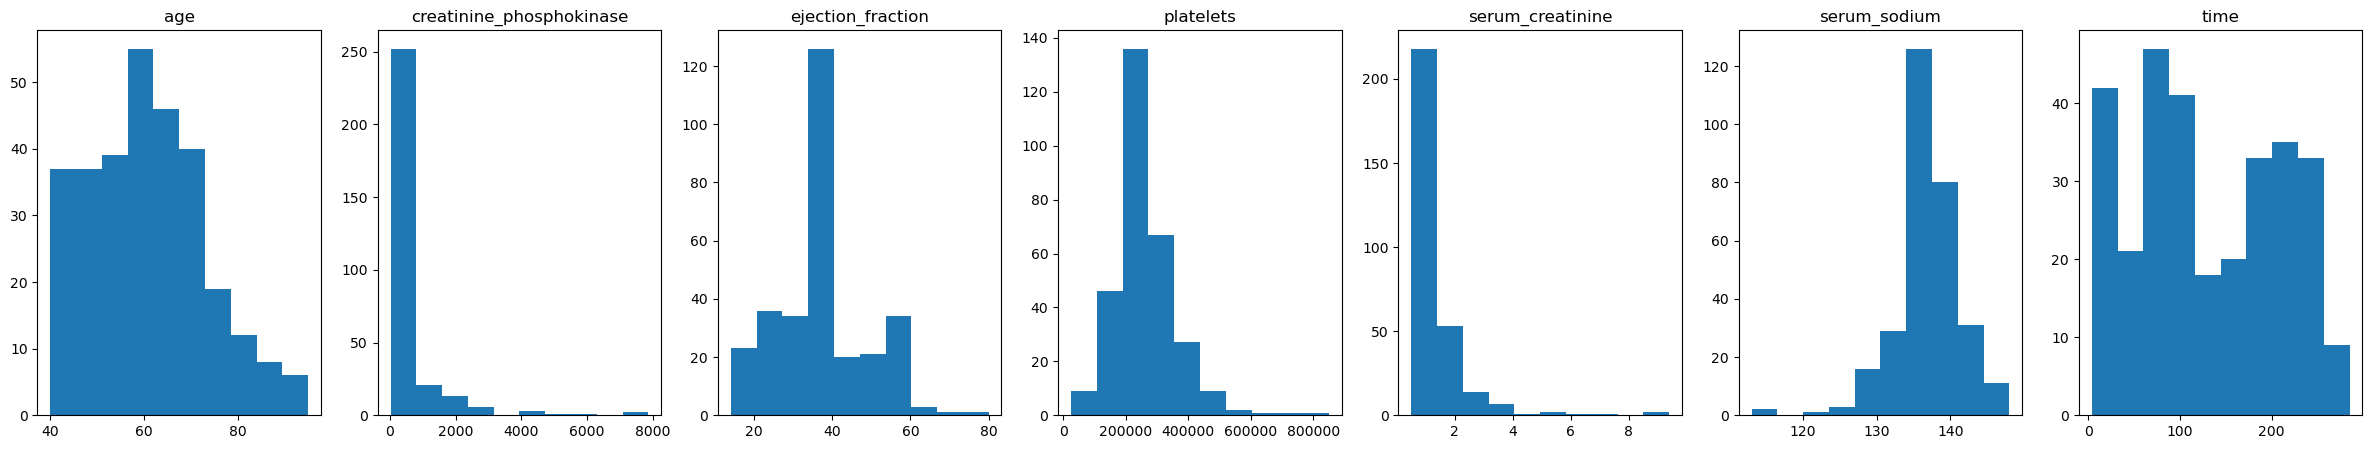

In [48]:
fig, ax = plt.subplots(1, 7)
fig.set_size_inches(30, 5)

for i,col in enumerate(data.columns):
    ax[i].hist(data[col])
    ax[i].set_title(col)

plt.show()

Seems like most of the variables are skewed to either the left or the right, but still mostly follow gaussian distributions. The "time" features seems almost bimodal or potentially uniform. We can standardize the data to make it a bit easier to work with.

In [49]:
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()
    
data.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02
mean,5.465713e-16,-1.336723e-17,8.911489e-18,1.009969e-16,1.307018e-16,-8.703554e-16,-2.376397e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.751511e+00,-5.759522e-01,-2.034976e+00,-2.436071e+00,-8.640608e-01,-5.354230e+00,-1.626775e+00
25%,-8.267382e-01,-4.795891e-01,-6.830351e-01,-5.199982e-01,-4.774043e-01,-5.949987e-01,-7.377627e-01
50%,-7.010562e-02,-3.420010e-01,-7.064906e-03,-1.388518e-02,-2.840761e-01,8.489153e-02,-1.966247e-01
75%,7.705972e-01,1.654510e-04,5.844090e-01,4.104318e-01,5.916232e-03,7.647817e-01,9.371883e-01
max,2.872354e+00,7.502063e+00,3.541779e+00,5.998124e+00,7.739045e+00,2.577822e+00,1.993696e+00


3.2 (5 pts) Compute the principal components of the data.  Plot a few of the largest eigenvectors and interpret them in terms of how there are modeling the structure of the data.

First, we can compute the covariance matrix of the data. 

In [50]:
data = data.iloc[:,:].values
cov = np.cov(data.T)
cov.shape

(7, 7)

Next, we can compute the eigenvalues and eigenvectors. Note that the eigenvectors are transposed, so, when you might normally interpret the vectors columnarly, here, they are represented as rows. Numpy does not sort the eigenvalues by default, so we can sort the values and vectors using np.argsort. This is done below and the output is shown.

In [59]:
# generate eigenvalues and vectors
eig_val, eig_vec = np.linalg.eig(cov)
eig_vec = eig_vec.T

# sort the items
idx = np.argsort(eig_val)
eig_val = eig_val[idx]
eig_vec = eig_vec[:,idx]

# reverse them so they are in decreasing order
eig_val = np.flip(eig_val)
eig_vec = np.flip(eig_vec, axis=0)

# display for user
print(f"eigen values:\n {eig_val}")
print(f"eigen vectors:\n {eig_vec}")

eigen values:
 [1.47457259 1.17559143 1.02947917 0.96622572 0.88773407 0.73744266
 0.72895436]
eigen vectors:
 [[-0.40331735  0.10671326 -0.10167226 -0.1179761   0.37056533 -0.81505355
   0.00779977]
 [ 0.82095373 -0.01299509  0.1822652  -0.36260682  0.10046937 -0.33440577
  -0.19809211]
 [-0.18075627  0.4694857   0.63358024 -0.15139902  0.44618596  0.2948224
  -0.19121352]
 [-0.00745938 -0.34417781  0.52875704  0.64191244 -0.135358   -0.26483252
  -0.31842166]
 [-0.17330471  0.39134776 -0.10691305 -0.18651897 -0.59856948 -0.10087872
  -0.6341378 ]
 [-0.24678636 -0.6814783  -0.04569638 -0.42971962  0.21428597  0.19389349
  -0.45213222]
 [-0.19925761 -0.17889238  0.51177697 -0.44741078 -0.48060342 -0.13795934
   0.46496174]]


Above, the eigenvectors are the principal components. Each of the eigenvectors represents some explained variance in the data, which is scaled by the eigenvectors. It is somewhat difficult to plot all of the eigenvectors here, because I lack the ability to display 7-dimensional data in a 2-dimensional plane. 

3.3 (5 pts) Plot, in decreasing order, the cumulative percentage of variance each eigenvector accounts for as a function of the eigenvector number.  These values should be in decreasing order of the eigenvalues. Interpret these results.

First, we can convert the eigenvalues to the % of variance in the data it describes.

In [62]:
ex_var = [0]
for val in eig_val:
    ex_var.append((val/sum(eig_val))*100)

And plot the values in decreasing order.

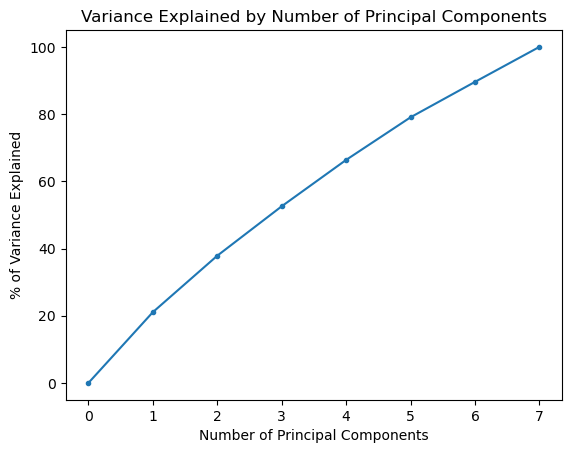

In [68]:
X = np.arange(0, 8, 1)
Y = np.cumsum(ex_var)

plt.plot(X, Y, marker='.')
plt.xlabel("Number of Principal Components")
plt.ylabel("% of Variance Explained")
plt.title("Variance Explained by Number of Principal Components")
plt.show()

This feels almost linear, let's make sure the eigenvalues are actually in decreasing order

In [66]:
print(ex_var)

[0, 21.06532277616897, 16.794163291782464, 14.706845251040498, 13.80322450962915, 12.681915330724665, 10.534895144357606, 10.413633696296642]


Ignoring the 0 (just used for plotting), we can see that, in decreasing order, each PC explains a decreasing amount of variance. It just so happens that in this dataset, the data is fairly evenly explained by each variable. This likely means that plotting this dataset in 7-dimensional space, we would see a 7-dimensional blob, which is likely what we will see in 2-dimensional space. 

3.4 (10 pts) Plot the original data projected into the space of the two principal eigenvectors (i.e. the eigenvectors with the largest two eigenvalues).  Be sure to either plot relative to the mean, or subtract the mean when you do this.  Interpret your results.  What insights can you draw?  Interpret the dimensions of the two largest principal components.  Which dimensions of the data are correlated?  Or anti-correlated?

First, we can convert the data so that it can be plotted against the principal components. We can do this by creating a projection matrix from the first two principal components.

In [69]:
proj_mat = (eig_vec[:][:2]).T
print(proj_mat)

[[-0.40331735  0.82095373]
 [ 0.10671326 -0.01299509]
 [-0.10167226  0.1822652 ]
 [-0.1179761  -0.36260682]
 [ 0.37056533  0.10046937]
 [-0.81505355 -0.33440577]
 [ 0.00779977 -0.19809211]]


Now that we have the projection matrix, we can convert the dataset to be plotted against the principal components by taking the dot product of the projection matrix and the data

In [75]:
X_pca = data.dot(proj_mat).T

Now, we can plot the data in 2-dimensions

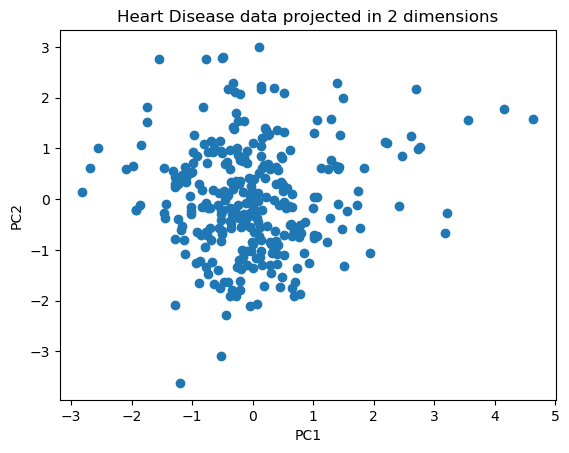

In [76]:
plt.scatter(X_pca[0], X_pca[1], label=data["DEATH_EVENT"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Heart Disease data projected in 2D")
plt.show()